In [167]:
import pandas as pd
import numpy as np

import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

import os

In [168]:
tf.test.is_built_with_cuda()

True

In [169]:
from functions import *

In [170]:
DATA_DIR = '../train-test-data'
features = ['CHILD_SEX','IDD_SCORE','AGE','HHID_count','HH_AGE','FOOD_EXPENSE_WEEKLY',
                 'NON-FOOD_EXPENSE_WEEKLY','HDD_SCORE','FOOD_INSECURITY','YoungBoys','YoungGirls',
                 'AverageMonthlyIncome','BEN_4PS','AREA_TYPE','FOOD_EXPENSE_WEEKLY_pc',
                 'NON-FOOD_EXPENSE_WEEKLY_pc','AverageMonthlyIncome_pc']
train = pd.read_csv(os.path.join(DATA_DIR, '2aii_train.csv'), index_col = 0)
test = pd.read_csv(os.path.join(DATA_DIR, '2aii_test.csv'), index_col = 0)
label = '2aii'

OUT_DIR = '../preliminary-image-data/2aii'

In [173]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

# Normalizing Variables
normalize = ['IDD_SCORE','AGE','HHID_count','HH_AGE','FOOD_EXPENSE_WEEKLY',
            'NON-FOOD_EXPENSE_WEEKLY','HDD_SCORE','FOOD_INSECURITY','YoungBoys','YoungGirls',
            'AverageMonthlyIncome','FOOD_EXPENSE_WEEKLY_pc','NON-FOOD_EXPENSE_WEEKLY_pc',
             'AverageMonthlyIncome_pc']
train_normal = train.copy()
test_normal = test.copy()
for f in normalize:
    train_normal[f] = sigmoid((train_normal[f]-train_normal[f].mean())/train_normal[f].std())
    test_normal[f] = sigmoid((test_normal[f]-test_normal[f].mean())/test_normal[f].std())

train_normal['BEN_4PS'] = train_normal['BEN_4PS']-1 
test_normal['BEN_4PS'] = test_normal['BEN_4PS']-1 

train_normal['label'] = np.where(train_normal['2aii']=="INCREASED RISK", 1, 0)
test_normal['label'] = np.where(test_normal['2aii']=="INCREASED RISK", 1, 0)

In [174]:
IMG_SIZE = (160, 160)

In [177]:
n = len(features)
w, h = IMG_SIZE
nw = 5
nh = (n+nw-1)//nw

for index, row in train_normal.iterrows():
    img = Image.new("RGB", IMG_SIZE)
    for i in range(0,nh):
        for j in range(0,nw):
            idx = i*nw+j
            if idx >= n: break 
            val = int(sigmoid(row[features[idx]])*255)

            r = ImageDraw.Draw(img)
            x = i*(h//nh)
            y = j*(w//nw)
            r.rectangle([(y,x), (y+w//nw, x+h//nh)], fill=(val,val,val))

    img.save(os.path.join(OUT_DIR,'train', str(row['label']), f'{index}.png'))

for index, row in test_normal.iterrows():
    img = Image.new("RGB", IMG_SIZE)
    for i in range(0,nh):
        for j in range(0,nw):
            idx = i*nw+j
            if idx >= n: break 
            val = int(sigmoid(row[features[idx]])*255)

            r = ImageDraw.Draw(img)
            x = i*(h//nh)
            y = j*(w//nw)
            r.rectangle([(y,x), (y+w//nw, x+h//nh)], fill=(val,val,val))

    img.save(os.path.join(OUT_DIR,'test', str(row['label']), f'{index}.png'))

In [178]:
train_ds = tf.keras.utils.image_dataset_from_directory(os.path.join(OUT_DIR, 'train'),
                                                       shuffle=True,
                                                       batch_size=8,
                                                       image_size=IMG_SIZE)
test_ds = tf.keras.utils.image_dataset_from_directory(os.path.join(OUT_DIR, 'test'),
                                                       shuffle=True,
                                                       batch_size=8,
                                                       image_size=IMG_SIZE)

Found 303 files belonging to 2 classes.
Found 303 files belonging to 2 classes.


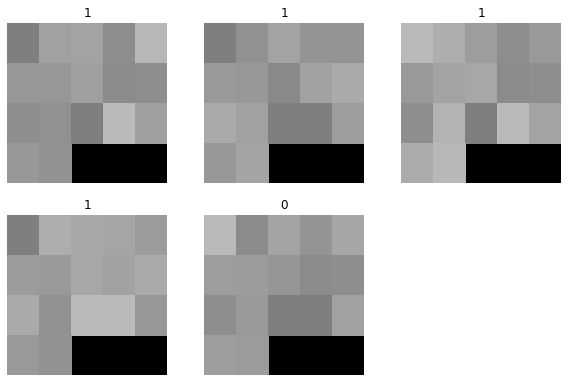

In [179]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(5):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [180]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [181]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(8, 5, 5, 1280)


In [182]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(8, 1280)
(8, 1)


In [183]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [189]:
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [193]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy', 
                       tf.keras.metrics.TruePositives(),
                       tf.keras.metrics.TrueNegatives(),
                       tf.keras.metrics.FalsePositives(),
                       tf.keras.metrics.FalseNegatives()])

In [194]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 160, 160, 3)]     0         
                                                                 
 tf.math.truediv_4 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_4 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_5   (None, 1280)             0         
 (GlobalAveragePooling2D)                                  

In [195]:
len(model.trainable_variables)

56

In [196]:
history = model.fit(train_ds,
                    epochs=10)

Epoch 1/10
38/38 [==============================] - 4s 21ms/step - loss: 0.4936 - accuracy: 0.8218 - true_positives_8: 248.0000 - true_negatives_5: 1.0000 - false_positives_5: 51.0000 - false_negatives_5: 3.0000
Epoch 2/10
38/38 [==============================] - 1s 17ms/step - loss: 0.5118 - accuracy: 0.8185 - true_positives_8: 248.0000 - true_negatives_5: 0.0000e+00 - false_positives_5: 52.0000 - false_negatives_5: 3.0000
Epoch 3/10
38/38 [==============================] - 1s 18ms/step - loss: 0.5009 - accuracy: 0.8251 - true_positives_8: 250.0000 - true_negatives_5: 0.0000e+00 - false_positives_5: 52.0000 - false_negatives_5: 1.0000
Epoch 4/10
38/38 [==============================] - 1s 17ms/step - loss: 0.4838 - accuracy: 0.8284 - true_positives_8: 250.0000 - true_negatives_5: 1.0000 - false_positives_5: 51.0000 - false_negatives_5: 1.0000
Epoch 5/10
38/38 [==============================] - 1s 17ms/step - loss: 0.4907 - accuracy: 0.8218 - true_positives_8: 249.0000 - true_negatives

In [187]:
scores = model.evaluate(test_ds, verbose=0)
loss, accuracy, tp, tn, fp, fn = scores
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
print(loss, accuracy, sensitivity, specificity)

0.4643292725086212 0.8250824809074402 1.0 0.0
